In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpi
%matplotlib inline

import skimage as sk
import numpy as np
from scipy.ndimage import gaussian_filter
import os

epsilon = 1e-6


def normalize(im):
    imax = np.max(im)
    imin = np.min(im)
    return (im - imin) / (imax - imin)


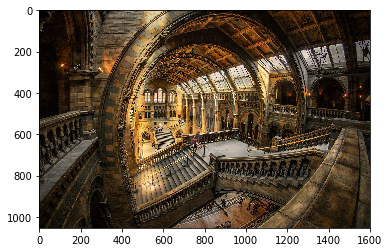

In [41]:
im = mpi.imread('./image1.jpg').astype(float) /255.0
plt.imshow(im)

In [43]:
noise = np.random.randn(*im.shape)
noise.shape
np.max(im)

1.0

Add signal-dependent noise

In [44]:
b1, b2 = 0.01, 1e-4
sig_noise = noise * np.sqrt(b1 * im + b2)

noisy_im = normalize(sig_noise + im)

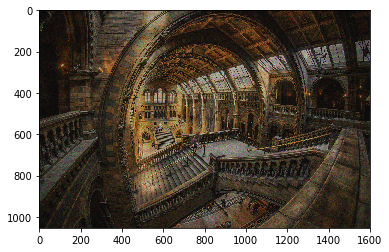

In [45]:
plt.imshow(noisy_im)

Test out Gaussian Denoising and the PSNR and then look at results from DnCNN

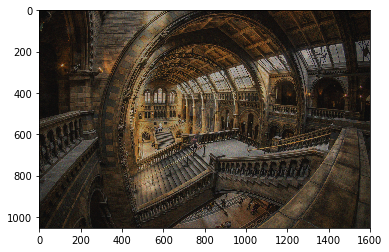

In [46]:
gauss_denoised = gaussian_filter(noisy_im,sigma=0.5)
plt.imshow(gauss_denoised)

calculate pixel-wise PSNR

In [47]:
def pix_psnr(im1, im2):
    return 10 * np.log10(1/(epsilon + np.power((im1 - im2), 2)))

def show_image_pair(psnr_im, im):
    fig, axes = plt.subplots(ncols=2,nrows=1, constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle("Image Comparison")

    axes[0].set_title("new map")
    axes[0].imshow(normalize(psnr_im))

    axes[1].set_title("Original Image")
    axes[1].imshow(normalize(im))

psnr_gauss = pix_psnr(im, noisy_im)

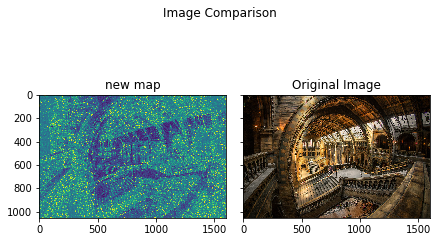

In [48]:
show_image_pair(psnr_gauss[:,:,1], im)

## Use DnCNN for denoising

In [49]:
from DnCNN.TrainingCodes.dncnn_keras.main_test import to_tensor, from_tensor
import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json

We want a function that can take the trained DnCNN and denoise any given image

In [51]:
model_path = "./DnCNN/TrainingCodes/dncnn_keras/models/DnCNN_sigma25"
with open(os.path.join(model_path, "model.json"), 'r') as json:
    model_json = json.read()
model = model_from_json(model_json)
model.load_weights(os.path.join(model_path, "model.h5"))

In [52]:
def dncnn(noisy_im):
    return from_tensor(model.predict(to_tensor(noisy_im.astype(np.float32))))

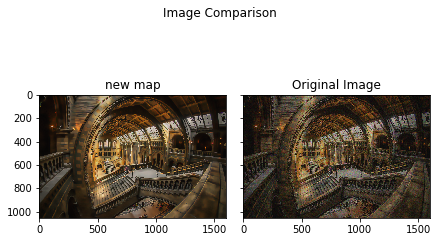

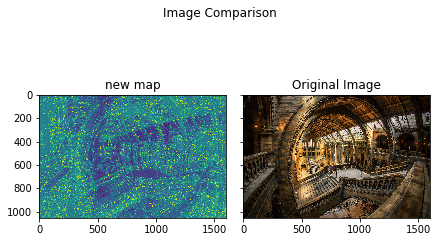

In [56]:
psnr_dnn = pix_psnr(im, nn_denoised)
show_image_pair(psnr_dnn[:,:,1], im)

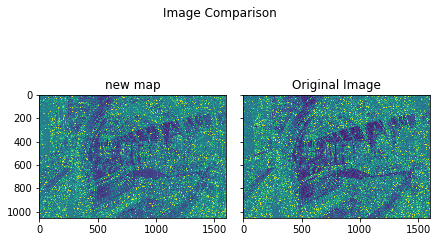

In [57]:
show_image_pair(psnr_dnn[:,:,1], psnr_gauss[:,:,1])

Looks to me like the psnr is overall more constant and higher valued in the dncnn denoised model, although there is still obvious structure in the image and the psnr is very high in bright regions. Looking at the dncnn denoised image you can definitely see a large smoothing effect in the bright regions that is noticeable artificial.

# Plot the PSNR as a function of image intensity
Look at the guassian denoised and the NN denoised

In [80]:
# We want to flatten and sort the psnr and image by intensity
flattened = np.array(
    [x.flatten() for x in [noisy_im[:, :, 1], psnr_dnn[:, :, 1], psnr_gauss[:, :, 1]]]
).transpose()

sorted_intensity = flattened[flattened[:,1].argsort()]
# plt.plot(x, y_dnn)
# plt.plot(x, y_gauss)
# plt.xlabel("Image Intensity")
# plt.ylabel("Pixelwise PSNR")
# plt.title("PSNR as function of intensity")
# plt.legend(["DnCNN", "Gaussian Denoiser"])
# plt.show()


In [81]:
print(sorted_intensity.shape)
print()

(1684800, 3)